In [1]:
! pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 2.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.9/266.9 kB 6.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 6.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the [`beans`](https://huggingface.co/datasets/beans) dataset, which is a collection of pictures of healthy and unhealthy bean leaves. 🍃



In [2]:
from datasets import load_dataset

In [3]:
ds = load_dataset('cifar10')
ds

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/home/aayush/a/dl_assignments/.venv/lib/python3.8/site-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /home/aayush/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [4]:
ex = ds['train'][400]
ex

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

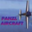

In [5]:
image = ex['img']
image

In [6]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

In [7]:
labels.int2str(ex['label'])

'airplane'

Turns out the leaf shown above is infected with Bean Rust, a serious disease in bean plants. 😢

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model. 

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [8]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

2023-05-18 12:30:51.210846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 12:30:54.367699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/aayush/a/dl_assignments/.venv/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


If we print a feature extractor, we can see its configuration.

In [9]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [10]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.0588,  0.0588,  0.0588,  ...,  0.0824,  0.0824,  0.0824],
          [ 0.0588,  0.0588,  0.0588,  ...,  0.0824,  0.0824,  0.0824],
          [ 0.0588,  0.0588,  0.0588,  ...,  0.0824,  0.0824,  0.0824],
          ...,
          [-0.3882, -0.3882, -0.3882,  ..., -0.4196, -0.4196, -0.4196],
          [-0.3882, -0.3882, -0.3882,  ..., -0.4196, -0.4196, -0.4196],
          [-0.3882, -0.3882, -0.3882,  ..., -0.4196, -0.4196, -0.4196]],

         [[ 0.2784,  0.2784,  0.2784,  ...,  0.2627,  0.2627,  0.2627],
          [ 0.2784,  0.2784,  0.2784,  ...,  0.2627,  0.2627,  0.2627],
          [ 0.2784,  0.2784,  0.2784,  ...,  0.2627,  0.2627,  0.2627],
          ...,
          [-0.2784, -0.2784, -0.2784,  ..., -0.3255, -0.3255, -0.3255],
          [-0.2784, -0.2784, -0.2784,  ..., -0.3255, -0.3255, -0.3255],
          [-0.2784, -0.2784, -0.2784,  ..., -0.3255, -0.3255, -0.3255]],

         [[ 0.6471,  0.6471,  0.6471,  ...,  0.6471,  0.6471,  0.6471],
          [ 0

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [11]:
def process_example(example):
    inputs = feature_extractor(example['img'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [12]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [13]:
ds = load_dataset('cifar10')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['img']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

Found cached dataset cifar10 (/home/aayush/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [14]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be 
applied in real time (on both samples and slices, as shown below)

In [15]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [16]:
import torch
import torch.nn as nn
from transformers import ViTFeatureExtractor, ViTModel

# Load the ViT model and feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
vit_model = ViTModel.from_pretrained(model_name)


In [17]:
# Create a custom classifier
import torch
import torch.nn as nn
from transformers import ViTFeatureExtractor, ViTModel
num_classes = 10  # Set the number of output classes

class ViTWithClassificationHead(nn.Module):
    def __init__(self, num_classes):
        super(ViTWithClassificationHead, self).__init__()
        self.vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.flatten = nn.Flatten()
        self.classification_head = nn.Sequential(
            nn.Linear(self.vit_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        self.classification_head = nn.Linear(self.vit_model.config.hidden_size, num_classes)
    
    def forward(self, pixel_values, attention_mask=None):
        outputs = self.vit_model(pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classification_head(pooled_output)
        return logits

# Example usage
num_classes = 10
model = ViTWithClassificationHead(num_classes)

# Print the model architecture
print(model)

ViTWithClassificationHead(
  (vit_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_feat

In [18]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [19]:
train_dataloader = torch.utils.data.DataLoader(prepared_ds['train'], batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(prepared_ds['test'], batch_size=32, shuffle=True)

In [20]:
num_epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        # Get data to cuda if possible
        images = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        # Forward pass
        logits = model(images)
        
        # Calculate loss
        loss = criterion(logits, labels)

        accuracy = (logits.argmax(dim=-1) == labels).float().mean()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx} of epoch {epoch+1} complete. Loss : {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")
        
    # Print the loss for every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy.item():.4f}")



Batch 0 of epoch 1 complete. Loss : 2.3269, Accuracy: 0.0625
Batch 100 of epoch 1 complete. Loss : 2.1510, Accuracy: 0.1875
Batch 200 of epoch 1 complete. Loss : 1.8300, Accuracy: 0.2812
Batch 300 of epoch 1 complete. Loss : 2.1183, Accuracy: 0.1562
Batch 400 of epoch 1 complete. Loss : 1.8910, Accuracy: 0.1875
Batch 500 of epoch 1 complete. Loss : 1.9931, Accuracy: 0.1875
Batch 600 of epoch 1 complete. Loss : 1.8101, Accuracy: 0.1562
Batch 700 of epoch 1 complete. Loss : 1.7860, Accuracy: 0.2188
Batch 800 of epoch 1 complete. Loss : 1.7933, Accuracy: 0.3750
Batch 900 of epoch 1 complete. Loss : 1.6543, Accuracy: 0.1562
Batch 1000 of epoch 1 complete. Loss : 1.8489, Accuracy: 0.3438
Batch 1100 of epoch 1 complete. Loss : 1.8531, Accuracy: 0.2500
Batch 1200 of epoch 1 complete. Loss : 1.7685, Accuracy: 0.2500
Batch 1300 of epoch 1 complete. Loss : 1.6882, Accuracy: 0.4062
Batch 1400 of epoch 1 complete. Loss : 2.0275, Accuracy: 0.3125
Batch 1500 of epoch 1 complete. Loss : 1.9126, Accur